In [1]:
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import numpy as np
from copy import deepcopy
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [3]:
df = pickle.load(open('../pickles/df_2015_16.pkl','rb'))

## Pickups Per Square Kilometer

In [4]:
X_columns = ['neighb','conditions', 'precip_count', 'temperature',\
             'day_of_week','month','time_of_day','neighb_type', 'start_event','end_event','holiday']
y_column = ['rides_per_sqkm']

X = df[X_columns]
y = df[y_column]


In [5]:
to_encode = []
for column in X_columns:
    if type(X[column][0])==str:
        to_encode.append(column)

for c in to_encode:
    encoded = pd.get_dummies(X[c])
    X = pd.concat([X, encoded], axis=1)
    X = X.drop([c],axis=1)
    
X = X.drop('MSG',axis=1)##Essentially a double entry on the same data, neighborhood

In [39]:
t0 = time()

regr = RandomForestRegressor()

param_grid = { 
    'n_estimators': [100,200],
    'max_features': ['auto'],
    'min_samples_leaf':[2, 5]
}

CV_rfr = GridSearchCV(estimator=regr, param_grid=param_grid, cv= 5)
CV_rfr.fit(X, np.ravel(y))

print((time()-t0)/60, 'minutes')

273.67072337468466 minutes


In [43]:
CV_rfr.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

regr = RandomForestRegressor(min_samples_leaf=5, n_estimators=200)

regr.fit(X_train, np.ravel(y_train))
pred = regr.predict(X_test)
regr.score(X_test, y_test)

/home/surajravi/miniconda/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.95157309856001493

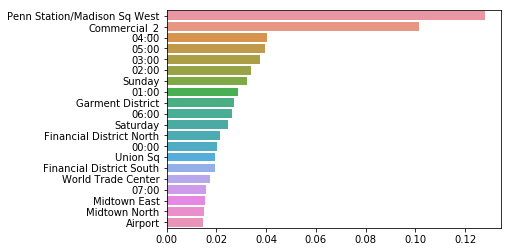

In [16]:
#Plot most important features for model

feat_importances = [(feat,m) for m, feat in enumerate(regr.feature_importances_)]
feat_importances = sorted(feat_importances,reverse=True)
features=[]
feat_imp=[]
for feat in feat_importances:
    features.append(X_train.columns[feat[1]]) 
    feat_imp.append(feat[0])

sns.barplot(y=features[:20], x = feat_imp[:20])

In [17]:
##Aggregate feature importances by type since most of the the features are currently one hot encoded

neighborhoods = list(df.neighb.unique())
weath_condition = list(df.conditions.unique())
day_of_week = list(df.day_of_week.unique())
months = list(df.month.unique())
t_of_d = list(df.time_of_day.unique())
neighb_type = list(df.neighb_type.unique())
holidays = list(df.holiday.unique())
events = list(df.end_event.unique())+list(df.start_event.unique())

scores = {'neighborhood':0.0, 'time':0.0, 'day_of_week':0.0, 'month':0.0,'weath_condition':0.0,'neighb_type':0.0,\
         'precip_count': 0.0, 'temperature':0.0, 'events':0.0,'holiday':0.0}

for feat, score in zip(features, feat_imp):
    if feat in neighborhoods:
        scores['neighborhood']+=score
    elif feat in t_of_d:
        scores['time']+=score
    elif feat in day_of_week:
        scores['day_of_week']+=score
    elif feat in months:
        scores['month']+=score
    elif feat in weath_condition:
        scores['weath_condition']+=score
    elif feat in neighb_type:
        scores['neighb_type']+=score
    elif feat=='precip_count':
        scores['precip_count']+=score
    elif feat=='temperature':
        scores['temperature']+=score
    elif feat in events:
        scores['events']+=score
    elif feat in holidays:
        scores['holiday']+=score
    else:
        print(feat, score)

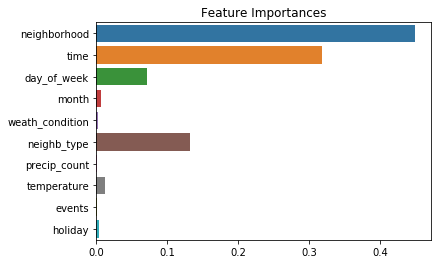

In [18]:
#Plot feature importances by type
feat_importances_2 = [scores[key] for key in scores.keys()]
features_2 = list(scores.keys())

ax = sns.barplot(y= features_2, x = feat_importances_2)
ax.set_title('Feature Importances')

plt.savefig('Feature_importances.pdf')

In [19]:
## Create dataframes to view feature importances by type
feature_rankings = pd.DataFrame(data = {'feature':features,'importance':feat_imp})

column_key={'temperature':'temperature','precip_count':'precip_count'}
for e in to_encode:
    for unique in df[e].unique():
        column_key[unique]=e
        
feature_rankings['feat_type'] = feature_rankings.apply(lambda row: column_key[row['feature']],axis=1)
cat_ranked_dfs = {}

for e in to_encode:
    curr = feature_rankings[feature_rankings['feat_type']==e].reset_index(drop=True).iloc[:5]
    cat_ranked_dfs[e] = curr
    
cat_ranked_dfs['neighb']

,feature,importance,feat_type
0,Penn Station/Madison Sq West,0.128133,neighb
1,Garment District,0.027060,neighb
2,Financial District North,0.021424,neighb
3,Union Sq,0.019599,neighb
4,Financial District South,0.019330,neighb


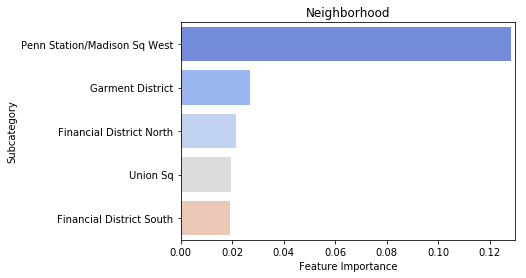

In [20]:
#Plot most important Neighborhood features
categ = 'neighb'
long_name = 'Neighborhood'
bar = sns.barplot(cat_ranked_dfs[categ]['importance'], cat_ranked_dfs[categ]['feature'],\
           palette = sns.color_palette("coolwarm", 7))

axes = bar.axes
axes.set_xlim(0,.13)
axes.set_xlabel('Feature Importance')
axes.set_ylabel('Subcategory')
plt.title('%s'% long_name)
plt.show()


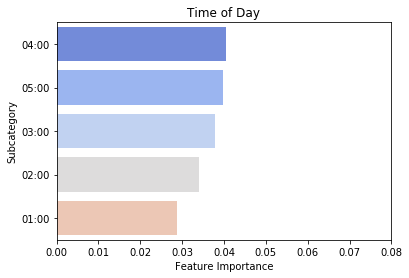

In [21]:
categ = 'time_of_day'
long_name = 'Time of Day'
bar = sns.barplot(cat_ranked_dfs[categ]['importance'], cat_ranked_dfs[categ]['feature'],\
           palette = sns.color_palette("coolwarm", 7))

axes = bar.axes
axes.set_xlim(0,.08)
axes.set_xlabel('Feature Importance')
axes.set_ylabel('Subcategory')
plt.title('%s'% long_name)

plt.show()

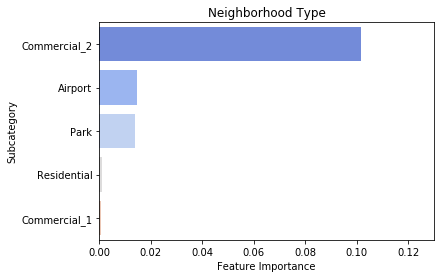

In [22]:
categ = 'neighb_type'
long_name = 'Neighborhood Type'
bar = sns.barplot(cat_ranked_dfs[categ]['importance'], cat_ranked_dfs[categ]['feature'],\
           palette = sns.color_palette("coolwarm", 7))

axes = bar.axes
axes.set_xlim(0,.13)
axes.set_xlabel('Feature Importance')
axes.set_ylabel('Subcategory')
plt.title('%s'% long_name)

plt.show()

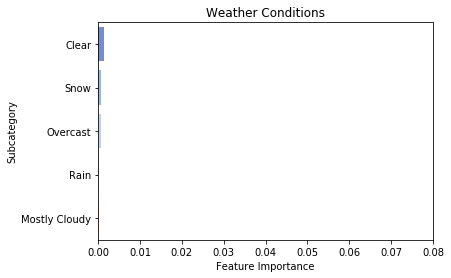

In [23]:
categ = 'conditions'
long_name = 'Weather Conditions'
bar = sns.barplot(cat_ranked_dfs[categ]['importance'], cat_ranked_dfs[categ]['feature'],\
           palette = sns.color_palette("coolwarm", 7))

axes = bar.axes
axes.set_xlim(0,.08)
axes.set_xlabel('Feature Importance')
axes.set_ylabel('Subcategory')
plt.title('%s'% long_name)

plt.show()

## View Residuals to Understand Issues

In [7]:
pred_all = regr.predict(X)

In [8]:
columns = ['date_time','neighb','pickup_taxizone_id','day_of_week','time_of_day','rides_per_sqkm']
predictions = df[columns]
predictions['predictions'] = pred_all

/home/surajravi/miniconda/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
predictions['resid'] = predictions.apply(lambda row: abs(row['rides_per_sqkm']- row['predictions']),axis=1)
predictions['resid_perc'] = predictions.apply(lambda row: row['resid']/row['rides_per_sqkm'], axis = 1)
predictions['over_under'] = predictions.apply(lambda row: "over" if row['predictions']>row['rides_per_sqkm'] \
                                              else 'under', axis=1)
predictions.head()

/home/surajravi/miniconda/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/surajravi/miniconda/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/surajravi/miniconda/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,date_time,neighb,pickup_taxizone_id,day_of_week,time_of_day,rides_per_sqkm,predictions,resid,resid_perc,over_under
0,2016-04-01,Alphabet City,4,Friday,00:00,57.179855,51.715883,5.463972,0.095558,under
1,2016-04-01,Battery Park,12,Friday,00:00,11.387670,15.345210,3.957540,0.347528,over
2,2016-04-01,Battery Park City,13,Friday,00:00,65.512065,67.395780,1.883715,0.028754,over
3,2016-04-01,Bloomingdale,24,Friday,00:00,46.791308,44.483708,2.307600,0.049317,under
4,2016-04-01,Central Park,43,Friday,00:00,11.632536,14.797257,3.164721,0.272058,over


In [30]:
## Cycle through all Categorical Variables, see where the RMSE is still highest 
RMSEs = []
X_cycle = deepcopy(X_columns)
X_cycle.remove('precip_count') 
X_cycle.remove('temperature')

for categ in X_cycle:
    t = df[categ].unique()
    for curr in t:
        if curr =='MSG':
            pass
        test_indices = list(X_test.index)
        curr_indices = list(df[df[categ]==curr].index)
        curr_test_indices = list(set(test_indices) & set(curr_indices))
        RMSE = np.sqrt(metrics.mean_squared_error(predictions.loc[curr_test_indices]['rides_per_sqkm'],\
                                                  predictions.loc[curr_test_indices]['predictions']))
        RMSEs.append((RMSE, curr))

In [31]:
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

MSE: 2899.57314622
RMSE: 53.8476846876


In [32]:
# Ten highest subcategories which the model struggled with
sorted(RMSEs,reverse=True)[0:10]

[(215.6752312329638, 'Concert_e'),
 (205.62481293086341, 'Hockey_e'),
 (198.10831658437723, 'Basketball_e'),
 (190.64026635033878, 'Hockey_s'),
 (184.08218261630378, 'Basketball_s'),
 (179.15896393383085, 'Snow'),
 (159.06109052517129, 'Penn Station/Madison Sq West'),
 (159.06109052517129, 'MSG'),
 (159.04016144067046, 'Concert_s'),
 (122.27740938014912, 'Midtown East')]

In [26]:
predictions[['neighb','date_time','day_of_week','time_of_day','rides_per_sqkm','predictions','resid','over_under']].\
sort_values('resid',ascending =False).head(20)

,neighb,date_time,day_of_week,time_of_day,rides_per_sqkm,predictions,resid,over_under
254733,Penn Station/Madison Sq West,2015-11-25 00:00:00,Wednesday,00:00,1685.212531,386.947450,1298.265081,under
375477,Lower East Side,2016-01-24 02:00:00,Sunday,02:00,0.880279,1178.929970,1178.049691,over
82664,Lower East Side,2016-03-13 02:00:00,Sunday,02:00,1.760558,1169.708806,1167.948247,over
263796,Penn Station/Madison Sq West,2016-05-01 23:00:00,Sunday,23:00,2320.891914,1186.913116,1133.978797,under
375423,Midtown North,2016-01-23 18:00:00,Saturday,18:00,1.501741,1094.596837,1093.095096,over
260690,Penn Station/Madison Sq West,2015-11-29 22:00:00,Sunday,22:00,2850.624733,1789.504703,1061.120030,under
256366,Penn Station/Madison Sq West,2015-11-26 07:00:00,Thursday,07:00,188.717317,1232.470645,1043.753328,over
338983,Penn Station/Madison Sq West,2016-01-01 07:00:00,Friday,07:00,170.507751,1205.350885,1034.843134,over
375475,East Village,2016-01-24 02:00:00,Sunday,02:00,1.137988,1033.310480,1032.172492,over
309363,Penn Station/Madison Sq West,2015-09-07 21:00:00,Monday,21:00,2502.987570,1499.870613,1003.116957,under


In [28]:
predictions[predictions['neighb'] == 'Penn Station/Madison Sq West'][['neighb','date_time','day_of_week','time_of_day','rides_per_sqkm','predictions','resid','over_under']].\
sort_values('resid',ascending =False).head(10)

,neighb,date_time,day_of_week,time_of_day,rides_per_sqkm,predictions,resid,over_under
254733,Penn Station/Madison Sq West,2015-11-25 00:00:00,Wednesday,00:00,1685.212531,386.947450,1298.265081,under
263796,Penn Station/Madison Sq West,2016-05-01 23:00:00,Sunday,23:00,2320.891914,1186.913116,1133.978797,under
260690,Penn Station/Madison Sq West,2015-11-29 22:00:00,Sunday,22:00,2850.624733,1789.504703,1061.120030,under
256366,Penn Station/Madison Sq West,2015-11-26 07:00:00,Thursday,07:00,188.717317,1232.470645,1043.753328,over
338983,Penn Station/Madison Sq West,2016-01-01 07:00:00,Friday,07:00,170.507751,1205.350885,1034.843134,over
309363,Penn Station/Madison Sq West,2015-09-07 21:00:00,Monday,21:00,2502.987570,1499.870613,1003.116957,under
387673,Penn Station/Madison Sq West,2015-12-25 07:00:00,Friday,07:00,122.500714,1104.792406,982.291691,over
332069,Penn Station/Madison Sq West,2015-09-25 19:00:00,Friday,19:00,384.056294,1360.741064,976.684770,over
257627,Penn Station/Madison Sq West,2015-11-27 07:00:00,Friday,07:00,395.644199,1344.872666,949.228467,over
309310,Penn Station/Madison Sq West,2015-09-07 20:00:00,Monday,20:00,2445.048043,1507.063053,937.984990,under


In [ ]:
#  All large penn station under predictions are extremely large events at MSG.  These large events are probably also
#  providing additional variability making it harder for the model to predict any event at MSG
#  11/25/2015 -- Stevie Wonder
#  05/01/2016 -- Pearl Jam
#  11/29/2015 -- Knicks, Rockets OT 
#  09/07/2015 -- U2

In [28]:
predictions.to_csv('../taxi_project/d3_projections.csv',index=False)

In [ ]:
# to export trees
# from sklearn import tree

# for i_tree, tree_in_forest in enumerate(regr.estimators_):
#     with open('tree_' + str(i_tree) + '.dot', 'w') as my_file:
#         my_file = tree.export_graphviz(tree_in_forest, out_file = my_file)

### Sum_fares

In [188]:
X_columns = ['neighb','conditions', 'precip_count', 'temperature',\
             'day_of_week','month','time_of_day','neighb_type', 'start_event','end_event','holiday']
y_column = ['fares_per_sqkm']

X = df[X_columns]
y = df[y_column]

In [189]:
to_encode = []
for column in X_columns:
    if type(X[column][0])==str:
        to_encode.append(column)

for c in to_encode:
    encoded = pd.get_dummies(X[c])
    X = pd.concat([X, encoded], axis=1)
    X = X.drop([c],axis=1)
    
X = X.drop('MSG',axis=1)##Essentially a double entry on the same data, neighborhood
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

In [190]:
t0 = time()
regr = RandomForestRegressor()
regr.fit(X_train, np.ravel(y_train))
print((time()-t0)/60, 'minutes')

0.848845374584198 minutes


In [191]:
pred = regr.predict(X_test)
regr.score(X_test, y_test)

0.78875146188168499

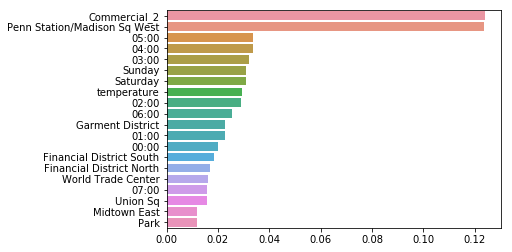

In [192]:
feat_importances = [(feat,m) for m, feat in enumerate(regr.feature_importances_)]
feat_importances = sorted(feat_importances,reverse=True)
features=[]
feat_imp=[]
for feat in feat_importances:
    features.append(X_train.columns[feat[1]]) 
    feat_imp.append(feat[0])

sns.barplot(y=features[:20], x = feat_imp[:20])